In [1]:
import numpy as np
import zarr
import dss.npy_dir
import dss.make_dataset
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Preparing data
This notebook creates an annotated data set for training DSS from lists of filenames for the song recordings and associated annotations.

This may look a bit complicated at first sight but only requires you to change two things in the next two cells:
1. The functions for loading the data (song recordings) and the annotations need to be adapted to work with your data.
2. Two lists with the names of data files (consumed by `load_data`) and the associated annotation files (consumed by `load_annotation`) need to be created.

The notebook as is works with a small toy data set (with song recordings from the data provided with [Stern 2014](https://www.janelia.org/lab/stern-lab/tools-reagents-data)) and with annotations produced by [Murthylab_FlySongSegmenter](https://github.com/murthylab/MurthyLab_FlySongSegmenter).

__Note:__ For this tutorial to work, you first need to download some data and example models (266MB) from [here](https://www.dropbox.com/sh/wnj3389k8ei8i1c/AACy7apWxW87IS_fBjI8-7WDa?dl=0) and put the four folders in the `tutorials` folder.

## Internals
The dataset is created in two steps. 

First, the data and annotations from different recordings are combined to a large matrix. This works even with large datasets that don't fit in memory thanks to [zarr](https://zarr.readthedocs.io/en/stable/tutorial.html#storage-alternatives), which provides an interface for on-disk-like arrays. The annotations are converted from lists of event times to one-hot-encoded probability vectors, (0 for no event, 1 for a specified short duration (default is $\pm$30 samples) surrounding the event).

Second, the zarr dataset is converted to a directory hierarchy of numpy files (npy) using `dss.npy_dir_save`. Numpy files allow extremely fast memory mapping, providing faster out-of-memory access than zarr during training. 



# Loader functions
Modify these two function to work with your data structures:
- `load_data` should accept a file name and return a `[nb_samples, nb_channels]` array.
- `load_annotation` should accept a file name and return a list of pulse times in units of samples (same samplerate as the data).

In [2]:
# This code works with the data in dat.raw
# @Junyu - the commented parts should work with your data from the google drive
# import scipy.io
# import h5py

def load_data(filename: str):
#     try:
#         f = scipy.io.loadmat(filename)
#         samples = f['recording']
#     except NotImplementedError:  # if mat file is in new v7.3 format
#         f = h5py.File(filename, mode='r')
#         samples= f['recording'][:].T
#     fs = 10_000
#     return samples, fs
    return np.load(filename)

def load_annotation(filename: str):
#     s = scipy.io.loadmat(filename)
#     pulsetimes = s['pInf']['wc'][0][0][:, 0].astype(np.float)
#     return pulsetimes
    return np.load(filename)['pulsetimes']

# Create lists with the names of data and annotation files
Lists of `data_files` and associated `annotation_files` are consumed by `load_data` and `load_annotation`, respectively.

In [3]:
data_dir = 'dat.raw/'

data_files = glob(data_dir + '*recording.npy')  # list all data files
annotation_files = [data_file.replace('_recording.npy', '_annotations.npz') for data_file in data_files]  # generate the names of associated annotation files

[print(f'data "{d}" with annotations in "{a}".') for d, a in zip(data_files, annotation_files)];

data "dat.raw/PS_20130702114557_ch13_recording.npy" with annotations in "dat.raw/PS_20130702114557_ch13_annotations.npz".
data "dat.raw/PS_20130625155828_ch11_recording.npy" with annotations in "dat.raw/PS_20130625155828_ch11_annotations.npz".
data "dat.raw/PS_20130628144304_ch15_recording.npy" with annotations in "dat.raw/PS_20130628144304_ch15_annotations.npz".
data "dat.raw/PS_20130702144748_ch15_recording.npy" with annotations in "dat.raw/PS_20130702144748_ch15_annotations.npz".
data "dat.raw/PS_20130628165930_ch11_recording.npy" with annotations in "dat.raw/PS_20130628165930_ch11_annotations.npz".
data "dat.raw/PS_20130625155828_ch7_recording.npy" with annotations in "dat.raw/PS_20130625155828_ch7_annotations.npz".
data "dat.raw/PS_20130625111709_ch10_recording.npy" with annotations in "dat.raw/PS_20130625111709_ch10_annotations.npz".


# Split filenames into train/val/test sets
Split the list of recordings into train/val/test files:
- `train` is used for optimizing the parameters during model fitting
- `val` is used during training to track model performance and save the current best model based on the performance on the validation data
- `test` is used to evaluate the best model after training is done and fine tune inference

In [4]:
np.random.seed(1)  # seed random number generator for reproducible splits
test_idx, val_idx, train_idx = np.split(np.random.permutation(len(data_files)), (1, 2))  # this will split the recordings into one for testing, one for validation, and the remained for training  
print('indices of test file(s):', test_idx, '\nindices of validation file(s):', val_idx, '\nindices of train files:', train_idx)

indices of test file(s): [6] 
indices of validation file(s): [2] 
indices of train files: [1 0 4 3 5]


# Initialize the data structure (store)
We use zarr as a data structure because it provides in-memory as well as out-of-memory arrays with the same, dict-like interface (similar to h5py).

Choose the zarr `store_type` based on the total size of your dataset:
- If it fits in memory, use a `DictStore`, which will place the data and annotation arrays in memory. 
- For "big data", use a `DirectoryStore`, this will place the arrays in chunked files in a directory.

Once all data and annotation files have been appended to the store, it will be saved as npy files in a directory hierarchy that mimics to the nested dictionary structure of the zarr store. For instance, the 
data set at `root['train']['x']` (the training data) will be stored as `store_name/train/x.npy`.
We use these npy files rather than the zarr store because access is faster.
The saving is done by `dss.npy_dir_save`. The directory structure is mapped back to a nested dictionary via `dss.npy_dir.load`.
If you used the `DirectoryStore` during assembly, you can delete the `*.zarr` directory after that final step.

The store also contains metadata which is important for training and inference:
- samplerates of the x and y data
- description of the different classes (names, types (segment or events)) - largely used to post-process the output of the network after inference (e.g. detect event times from the probabilities produced by the network).

These metadata will be saved with the data in the npy directories.

In [5]:
samplerate = 10_000  # this is the sample rate of your data and the pulse times

root = dss.make_dataset.init_store(
        nb_channels=1,  # number of channels/microphones in the recording
        nb_classes=2,  # number of classes to predict - [noise, pulse]
        samplerate=samplerate,  # make sure audio data and the annotations are all on the same sampling rate
        class_names=['noise', 'pulse'],
        class_types=['segment', 'event'],
        store_type=zarr.DictStore,  # use DirectoryStore for big data        
        store_name='dsec_raw.zarr', # only used with DirectoryStore - this is the path to the directory created
        )

## Load the individual data files

In [6]:
for idx, (data_file, annotation_file) in tqdm(enumerate(zip(data_files, annotation_files)), total=len(data_files)):
    # First, load the data
    x = load_data(data_file)  # x should be [nb_samples, nb_channels]
   
    # Second, load the annotations
    pulse_samples = load_annotation(annotation_file)  # y should be a list of pulsetimes in units of samples
    
    # Convert the list of pulse samples to a one-hot-encoded vector of probabilities [times, events]
    y = dss.make_dataset.events_to_probabilities(pulse_samples.astype(np.int), desired_len = x.shape[0])
    
    # Determine whether file is test/val/train
    if idx in test_idx:
        target = 'test'
    elif idx in val_idx:
        target = 'val'
    elif idx in train_idx:
        target = 'train'
    else:
        continue

    offset_seconds = root[target]['x'].shape[0] / samplerate
    
    # Add the recording (x) and the prediction target (y) to the data set
    root[target]['x'].append(x)
    root[target]['y'].append(y)
        
    # Also, save the pulses times for evaluation purposes
    pulse_times = pulse_samples.astype(np.float) / samplerate
    root[target]['eventtimes'].append(np.stack([np.full_like(pulse_times, np.nan), offset_seconds + pulse_times], axis=1))
       
    # Keep track of which samples in the data come from which file 
    root.attrs[f'filename_{target}'].append(data_file)
    root.attrs[f'filename_startsample_{target}'].append(root[target]['x'].shape[0])
    root.attrs[f'filename_endsample_{target}'].append(root[target]['x'].shape[0] + x.shape[0])

In [7]:
# Save the zarr store as a hierarchy of npy files
dss.npy_dir.save('dat/dmel_single_raw.npy', root)

Finally, plot x/y values from the beginning and the end of the dataset to make sure everything is well aligned.
The annotations were produced by `FlySongSegmenter` - as you can see, there is room for improvement...

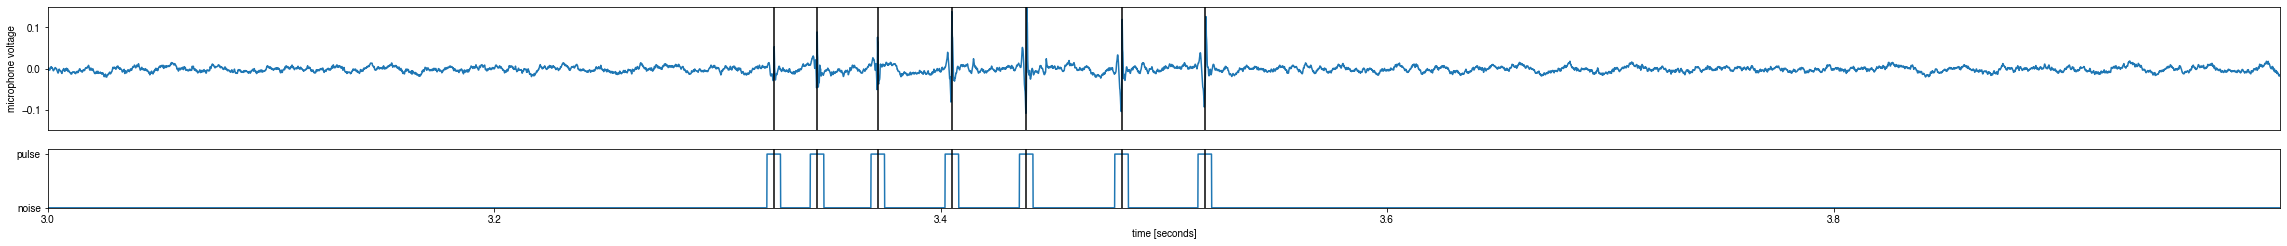

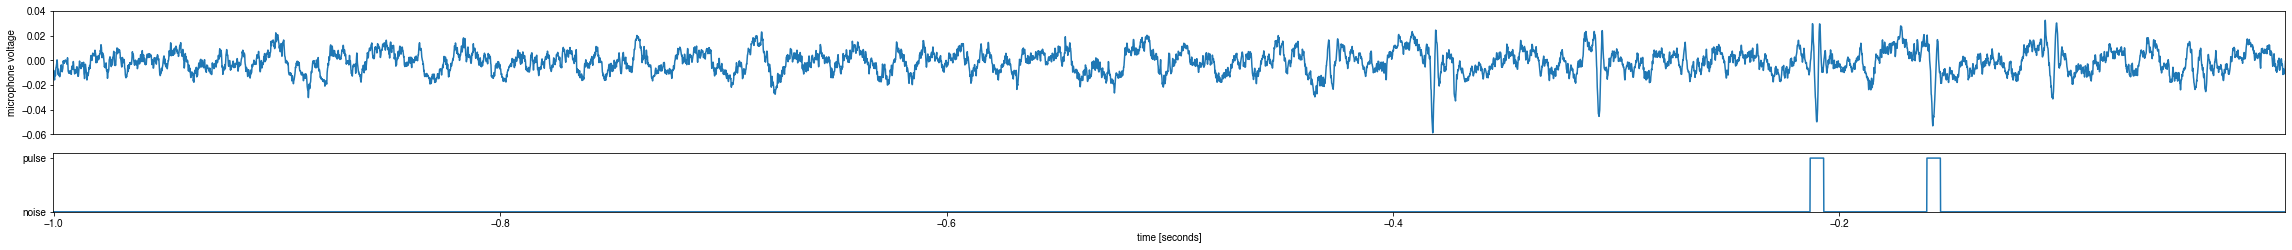

In [8]:
for t0 in [30_000, -10_001]:
    t1 = t0 + 10_000
    plt.gcf().set_size_inches(40, 5)
    T = np.arange(t0, t1) / root.attrs['samplerate_x_Hz']
    plt.subplot(211)
    plt.plot(T, root['train']['x'][t0:t1])
    plt.xticks([])
    plt.ylabel('microphone voltage')
    plt.xlim(min(T), max(T))    
    [plt.axvline(t, c='k') for t in root['train']['eventtimes'][:, 1] if (t>min(T) and t<max(T))] 

    plt.subplot(413)                      
    plt.plot(T, root['train']['y'][t0:t1, 1])
    plt.ylim(0, 1.1)
    plt.yticks([0, 1], labels=root.attrs['class_names'] )
    plt.xlabel('time [seconds]')
    plt.xlim(min(T), max(T))
    [plt.axvline(t, c='k') for t in root['train']['eventtimes'][:, 1] if (t>min(T) and t<max(T))] 

    plt.show()